# Biot-Savart in Julia

### Units
The full Biot-Savart integral is
$$
\mathbf{B}\left( \mathbf{r} \right) = \frac{\mu_0}{4\pi} \int_C \frac{I\, d\mathbf{l}\, \times \mathbf{r'}}{ \left| \mathbf{r'} \right|^3 },
$$
where $\mathbf{r'}$ is the vector connecting the point of observation, $\mathbf{r}$, to the current-carrying line element $d\mathbf{l}$. The units of $\mu_0$ are $\mathrm{H}/\mathrm{m} \equiv \mathrm{T}\cdot\mathrm{m}/\mathrm{A}$, so as expected the units of the entire integral are in $\mathrm{T}$. We prefer to express magnetic fields in $\mathrm{G} \equiv 10^{-4} \mathrm{T}$. If we specify our paths in millimeters, this means that the prefactor $\mu_0/4\pi \approx 10^{-7} \mathrm{H/m}$ drops out, and we can get away with less bookkeeping.

This has one consequence for the gradients and curvatures that we calculate. The length units of these will now also be assumed to be in millimeters, so if we prefer to express a gradient in $\mathrm{G/cm}$ we'll have to multiply by a factor of 10, and if we want to express a curvature in $\mathrm{G/cm}^2$ that warrants a factor 100.

In [1]:
using ForwardDiff
using Plots, Interact
using BenchmarkTools
Plots.pyplot()

# Load our own package defining coil paths and Biot-Savart integrals
using Magnetostatics

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-14566044172006197778\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-15673474588272827814\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-14566044172006197778\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [2]:
fieldXComponent

fieldXComponent (generic function with 1 method)

In [3]:
bias=[0,0,0]
normGrad(x) = ForwardDiff.gradient(x->(fieldNormplusBias(x,path,dl,bias)),x)
normCurve(x) = ForwardDiff.hessian(x->(fieldNormplusBias(x,path,dl,bias)),x)

normCurve (generic function with 1 method)

In [39]:
#warmup - let JIT compiler compile the functions
plt2 = path3d()
angRes = 0.00002;
t = 0.0:angRes:(2*pi*1.0);
uppath = permutedims(hcat(25 .*cos.(t),25 .*sin.(t),zero(t).+12.5))
sign=400;
updl = sign.*pathVec(uppath);

sign=-200;
downpath=permutedims(hcat(25 .*cos.(t),25 .*sin.(t),zero(t).-12.5))
downdl=sign.*pathVec(downpath);
path=hcat(uppath,downpath);
dl=hcat(updl,downdl);
probeLocation = [0, 0, 0];


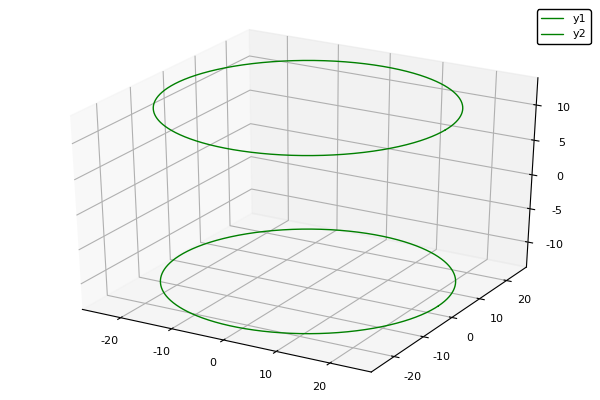

In [31]:
path3d!(uppath[1,:],uppath[2,:],uppath[3,:],color = "green")
path3d!(downpath[1,:],downpath[2,:],downpath[3,:],color = "green")

In [42]:
fieldNormplusBias(probeLocation,path,dl,bias)

35.967021040626

In [41]:
fieldNorm([0.1,0,0],path,dl)-fieldNorm([0,0,0],path,dl)

0.0009317724525459425

In [12]:
normGrad(probeLocation)

3-element Array{Float64,1}:
 -3.4025676968502347e-6
  6.737504971700202e-11
 -2.926019497665222e-12

In [169]:
normCurve(probeLocation)

3×3 Array{Float64,2}:
  0.594614     2.54218e-11  -6.99246e-6 
  2.54218e-11  0.594616      8.74062e-11
 -6.99246e-6   8.74062e-11   8.90896e-11

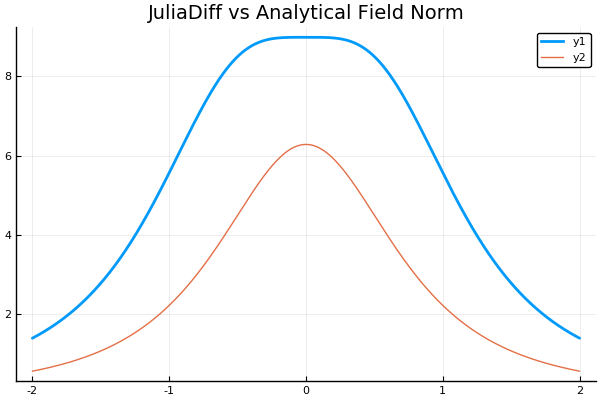

In [35]:
#compare the field generated by a single loop and the analytical results

wow = Array{Float64,1}();
for i=-2:0.001:2
    push!(wow,fieldNormplusBias([0.0,0.0,i],path,dl,bias))
end

z = collect(-2:0.001:2);
realNormZ = 2*pi*1*(1).*(1^2 .+ z.^2).^(-1.5)
plot(z,wow,linewidth=2,title="JuliaDiff vs Analytical Field Norm")
plot!(z,realNormZ)

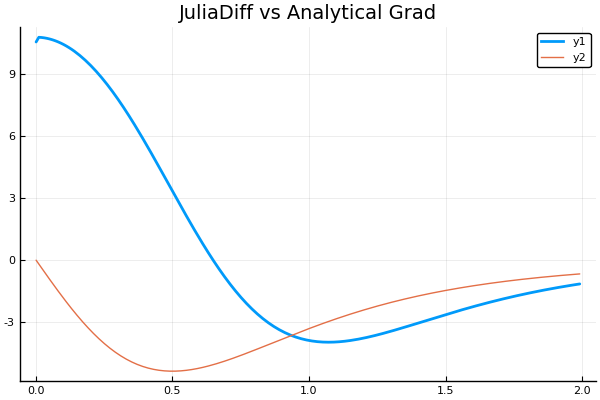

In [53]:
wow = Array{Float64,1}();
for i=0.001:0.01:2
    push!(wow,normGrad([0.0,0.0,i])[3])
end

z = collect(0.001:0.01:2);
realGradZ = 2*pi*1*(1)*(-3*z).*(1^2 .+ z.^2).^(-2.5)
plot(z,wow,linewidth=2,title="JuliaDiff vs Analytical Grad")
plot!(z,realGradZ)

In [36]:
plt = plot(linewidth=2,title = "Numerical difference between JuliaDiff and Analytical Grad")
for angRes in [0.01,0.003,0.001,0.0001]
    t = 0.0:angRes:(2*pi*1.0);
    path = permutedims(1.0.*hcat(cos.(t),sin.(t),zero(t)))
    dl = pathVec(path);

    wow = Array{Float64,1}();
    for i=0.001:0.01:2
        push!(wow,normGrad([0.0,0.0,i])[3])
    end
    plot!(z,log10.(abs.((wow-realGradZ)./realGradZ)),label = "angRes = $angRes")
end

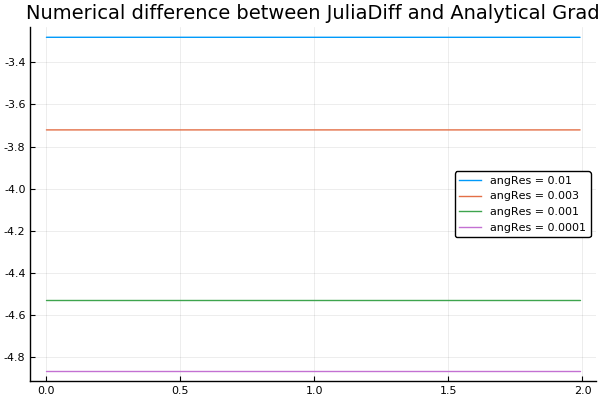

In [37]:
plt

In [ ]:
bzDD = @. 2*pi*(1.0)*(-3.0)*(1.0^2-4.0*z^2)/sqrt((1.0^2 + z^2)^7)
wowww = Array{Float64,1}()
    for i in z
        push!(wowww,normCurve([0.0,0.0,i])[3,3])
    end
plot(z,wowww,linewidth=2,title="ForwardDiff.hessian vs Analytical Curvature")
plot!(z,bzDD)

In [ ]:
bx = Array{Float64,1}();
by = Array{Float64,1}();
bz = Array{Float64,1}();
bgrad = Array{Float64,1}();
bcx = Array{Float64,1}();
bcy = Array{Float64,1}();
bcz = Array{Float64,1}();
for i=-4:0.1:4
    push!(bx,fieldXComponent([0.0,0.0,i],path,dl))
    push!(by,fieldYComponent([0.0,0.0,i],path,dl))
    push!(bz,fieldZComponent([0.0,0.0,i],path,dl))
    push!(bgrad,normGrad([0.0,0.0,i])[3])
    nc = normCurve([0.0,0.0,i])
    push!(bcz,nc[3,3])
    push!(bcy,nc[2,2])
    push!(bcx,nc[1,1])
end

In [24]:
# Switch plotting backends to get static view
#pyplot()
plotly()

plot(-4:0.1:4,bgrad*10,title = "magnetic field gradient (G/(cm*Amp)")

<!DOCTYPE html>
 
 
 Plots.jl

In [25]:
bgrad[41]*10

-0.0010314135946255468

In [26]:
bx[41]

2.4038312215991634e-6

In [27]:
by[41]

-0.00019340604356975498

In [28]:
bz[41]

-0.14328143861427003

In [29]:
sqrt(bx[41].^2+by[41].^2+bz[41].^2)

0.14328156916732496

In [45]:
plotly()
plot(-4:0.1:4,bcx*100,title = "magnetic field curvature (G/(cm^2 * Amp))")
plot!(-4:0.1:4,bcy*100)
plot!(-4:0.1:4,bcz*100)

<!DOCTYPE html>
 
 
 Plots.jl

In [46]:
bcx[41]*100

0.08342376825100226

In [47]:
bcy[41]*100

0.08314218998073171

In [48]:
bcz[41]*100

0.0015406117637208928

In [49]:
#find the analytical solution of the coil design by treating each layer by a single loop
anaNormZ = Array{Float64,1}();

z = collect(-4:0.1:4)
anaNormZ=zeros(length(z))

###contribution from normal winding coils############

print(layers)

for j=1:layers
    r=bucket_radius+(j-1).*3.5
    for i=1:Int(length(normalHeight)/2)
        anaNormZ = anaNormZ.+2*pi*1*(r.^2).*(r.^2 .+ (z.-normalHeight[i]).^2).^(-1.5)
    end

    for i=Int(length(normalHeight)/2)+1:Int(length(normalHeight))
        anaNormZ = anaNormZ.+sign.*2*pi*1*(r.^2).*(r.^2 .+ (z.-normalHeight[i]).^2).^(-1.5)
    end
end

###contribution from transition part in normal winding coils############
r=bucket_radius+3.5/2
anaNormZ = anaNormZ.+2*pi*1*(r.^2).*(r.^2 .+ (z.-normalHeight[pitch].-3.5).^2).^(-1.5)
anaNormZ = anaNormZ.+sign.*2*pi*1*(r.^2).*(r.^2 .+ (z.-normalHeight[pitch*2].-3.5).^2).^(-1.5)

bnorm=(bx.^2 .+by.^2 .+bz.^2).^(1/2)
plot(z,bz,linewidth=2,title="Realistic vs Analytical Field Norm")
plot!(z,-anaNormZ)




2

<!DOCTYPE html>
 
 
 Plots.jl

In [22]:
bnorm[41]

UndefVarError: UndefVarError: bnorm not defined

In [23]:
@btime normCurve([0.0,0.0,0.0])*100

  1.108 s (61 allocations: 758.53 MiB)


3×3 Array{Float64,2}:
 0.450347     9.65406e-5   0.0132973
 9.65406e-5   0.445012    -0.0987673
 0.0132973   -0.0987673    0.0227642

In [24]:
@btime normGrad([0.0,0.0,0.0])*10

  445.657 ms (54 allocations: 260.20 MiB)


3-element Array{Float64,1}:
 -3.880643314785868e-5 
  0.0004389596308553169
 -0.021348744979773203 

In [25]:
@btime fieldNorm([0.0,0.0,0.0],path,dl)

  62.879 ms (50 allocations: 65.05 MiB)


6.3140322101369835